#Ambientação do notebook

In [1]:
!pip install -U -q PyDrive

In [107]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelBinarizer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id': '1-C4iOW6z7oAtWCHhwuC-IeTxp8COwbxj'})
downloaded.GetContentFile('client.csv')

In [6]:
# Dados lidos do arquvio csv
client = pd.read_csv('client.csv')


# Mostrando primeiros registros do Dataframe
client.describe()

,Unnamed: 0,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
count,1.858800e+05,185880.000000,185880.000000,185880.000000,1.858800e+05,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000,185880.000000
mean,5.912966e+06,0.011116,0.007510,0.000468,1.292035e-17,0.017316,0.000716,0.053117,0.000151,0.021180,0.010015,0.000522,0.340515
std,3.434754e+06,0.018151,0.012895,0.016229,1.000003e+00,0.025724,0.014979,0.039685,0.012272,0.034374,0.017089,0.022838,0.473884
min,0.000000e+00,0.000000,0.000000,0.000000,-2.619104e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.921000e+06,0.002135,0.001188,0.000000,-6.324168e-01,0.000000,0.000000,0.026415,0.000000,0.000000,0.003056,0.000000,0.000000
50%,5.895934e+06,0.005607,0.002949,0.000000,5.769572e-02,0.011494,0.000000,0.045283,0.000000,0.009174,0.005417,0.000000,0.000000
75%,8.908545e+06,0.012428,0.008355,0.000000,6.014207e-01,0.022989,0.000000,0.067925,0.000000,0.027523,0.011252,0.000000,1.000000
max,1.188632e+07,1.000000,1.000000,1.000000,4.163517e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Correlações

In [10]:
##Aqui nós iremos gerar uma matriz que indica a porcentagem de correlação entre os atributos
matriz_corr = client.corr().style.background_gradient(cmap='coolwarm')
matriz_corr

,Unnamed: 0,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,ind_atrito,ind_engaj
Unnamed: 0,1.000000,-0.001449,0.001522,-0.002444,-0.000885,0.002616,-0.000890,-0.000765,-0.004190,0.003100,-0.000362,-0.002664,0.002035
vlr_credito,-0.001449,1.000000,0.280953,0.006309,0.071460,0.096261,0.009918,0.398583,0.019903,0.098304,0.593851,0.011959,0.070471
vlr_saldo,0.001522,0.280953,1.000000,0.000226,0.074541,0.235828,0.002335,0.088389,0.018893,0.007249,0.160302,0.017218,0.170425
num_atend_atrs,-0.002444,0.006309,0.000226,1.000000,0.001361,0.032058,0.531965,0.019272,-0.000354,0.002933,0.006910,0.021113,0.021248
vlr_score,-0.000885,0.071460,0.074541,0.001361,1.000000,0.076976,0.006721,0.094354,0.002783,-0.293389,0.078622,0.004139,0.066338
num_produtos,0.002616,0.096261,0.235828,0.032058,0.076976,1.000000,0.052517,0.399924,0.000552,0.001635,0.071313,0.007039,0.707495
num_atend,-0.000890,0.009918,0.002335,0.531965,0.006721,0.052517,1.000000,0.028077,-0.000586,0.000265,0.014571,0.011490,0.030704
qtd_oper,-0.000765,0.398583,0.088389,0.019272,0.094354,0.399924,0.028077,1.000000,0.008165,0.151486,0.299594,0.005816,0.296881
qtd_reclm,-0.004190,0.019903,0.018893,-0.000354,0.002783,0.000552,-0.000586,0.008165,1.000000,-0.001011,0.017440,0.537171,0.005056
qtd_restr,0.003100,0.098304,0.007249,0.002933,-0.293389,0.001635,0.000265,0.151486,-0.001011,1.000000,0.053812,-0.001945,0.002315


In [11]:
##Aqui nós iremos listar as melhores correlação para a nossa resposta de engajado ou não

target_corr = matriz_corr.data.ind_engaj
df_corr = target_corr.abs().sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')
df_corr

,ind_engaj
ind_engaj,1.000000
num_produtos,0.707495
qtd_oper,0.296881
vlr_saldo,0.170425
vlr_credito,0.070471
vlr_score,0.066338
vlr_renda,0.034249
num_atend,0.030704
num_atend_atrs,0.021248
ind_atrito,0.006447


Observando os dados acima, podemos perceber que há uma grande correlação entre o número de produtos de um usuário e o seu índice de engajamento. Quando revisitamos os dados fornecidos pelo cliente, percebemos que esta coluna faz parte da regra de negócio da definição de um cliente engajado. Sendo assim, temos a necessidade de gerar um modelo que também consiga prever sem esta coluna e possa indicar um possível futuro cliente engajado. Por isso iremos entregar dois modelos. Um que responde a questão do nosso usuário e outro que o faz poder definir questões estratégicas futuras. 

#Cliente engajado

###Treinamento Teste

Na cédula abaixo nós temos a divisão da tabela entre treinamento e teste, note que estamos defifindo 80% dos dados para treinamento e 20% para os testes. Outro fator importante, é que usamos o random_state que faz com que a população de dados seja a mesma do início ao fim do notebook e isso garante que podemos comparar os modelos entre si e observar o índice de acerto daquele mesmo conjunto. 

In [109]:
from sklearn.model_selection import train_test_split

cols = ["num_produtos", "qtd_oper"]

# Dividindo x e y
x = client[cols]
y = client['ind_engaj']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Hiperparâmetros

###Arvore de decisão PARÂMETRO 1

In [19]:
avd = DecisionTreeClassifier(criterion='entropy', random_state=42)
avd.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [20]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [21]:
accuracy_score(y_test, y_pred_avd)

0.9789918226812998

Precisão

In [22]:
precision_score(y_test, y_pred_avd)

0.9688548903286238

Recall

In [23]:
recall_score(y_test, y_pred_avd)

0.9701422541816477

####Matriz de confusão

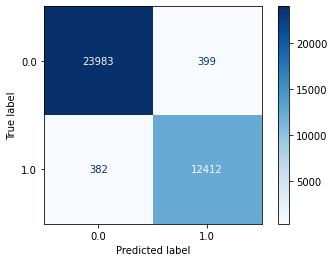

In [24]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

###Árvore de decisão PARÂMETRO 2

In [25]:
avd = DecisionTreeClassifier(criterion='gini', random_state=42)
avd.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [27]:
accuracy_score(y_test, y_pred_avd)

0.9780503550677857

Precisão

In [28]:
precision_score(y_test, y_pred_avd)

0.968622848200313

Recall

In [29]:
recall_score(y_test, y_pred_avd)

0.9675629201188057

####Matriz de confusão

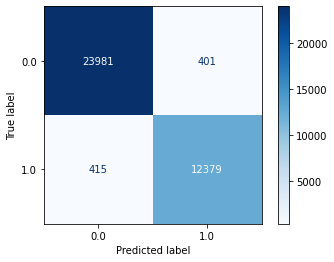

In [30]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

###Arvore de decisão PARÂMETRO 3

In [31]:
avd = DecisionTreeClassifier(criterion='entropy', max_features='auto', random_state=42)
avd.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_features='auto',
                       random_state=42)

In [32]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [33]:
accuracy_score(y_test, y_pred_avd)

0.9789111254572843

Precisão

In [34]:
precision_score(y_test, y_pred_avd)

0.9689940643548891

Recall

In [35]:
recall_score(y_test, y_pred_avd)

0.9697514459903079

####Matriz de confusão

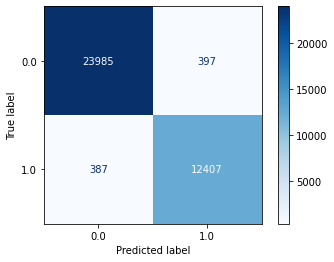

In [36]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

###Arvore de decisão PARÂMETRO 4

In [37]:
avd = DecisionTreeClassifier(criterion='entropy',max_features='log2', random_state=42)
avd.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=42)

In [38]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [39]:
accuracy_score(y_test, y_pred_avd)

0.9789111254572843

Precisão

In [40]:
precision_score(y_test, y_pred_avd)

0.9689940643548891

Recall

In [41]:
recall_score(y_test, y_pred_avd)

0.9697514459903079

####Matriz de confusão

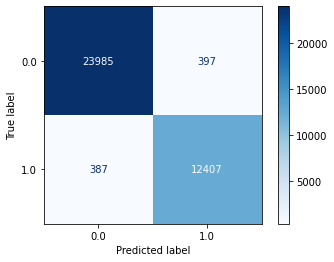

In [42]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

###Arvore de decisão PARÂMETRO 5

In [110]:
avd = DecisionTreeClassifier(criterion='entropy',max_features='sqrt', random_state=42)
avd.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=42)

In [111]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [112]:
accuracy_score(y_test, y_pred_avd)

0.9881106089950505

Precisão

In [113]:
precision_score(y_test, y_pred_avd)

0.9670296430732003

Recall

In [114]:
recall_score(y_test, y_pred_avd)

0.9995310301703924

####Matriz de confusão

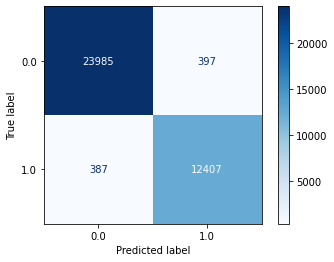

In [48]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

###Random Forest PARÂMETRO 1

In [49]:
avd = RandomForestClassifier(criterion='entropy',max_features='sqrt', random_state=42)
avd.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       random_state=42)

In [50]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [51]:
accuracy_score(y_test, y_pred_avd)

0.981332042177749

Precisão

In [52]:
precision_score(y_test, y_pred_avd)

0.9690649713133819

Recall

In [53]:
recall_score(y_test, y_pred_avd)

0.9769423167109582

####Matriz de confusão

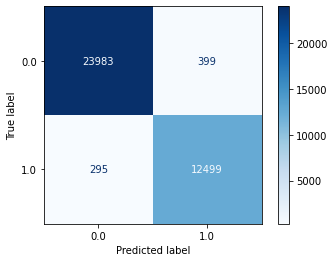

In [54]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

In [55]:
rdf = RandomForestClassifier()
rdf.fit(x_train, y_train)


RandomForestClassifier()

In [56]:
y_pred_rdf = rdf.predict(x_test)

###Random Forest PARÂMETRO 2

In [57]:
avd = RandomForestClassifier(criterion='gini', random_state=42)
avd.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [59]:
accuracy_score(y_test, y_pred_avd)

0.9815741338497955

Precisão

In [60]:
precision_score(y_test, y_pred_avd)

0.9690138662948331

Recall

In [61]:
recall_score(y_test, y_pred_avd)

0.9777239330936376

####Matriz de confusão

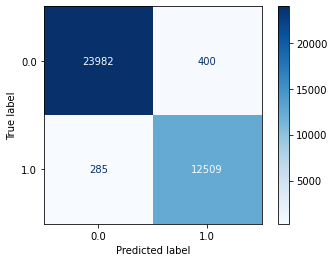

In [62]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

In [63]:
rdf = RandomForestClassifier()
rdf.fit(x_train, y_train)


RandomForestClassifier()

In [64]:
y_pred_rdf = rdf.predict(x_test)

###Random Forest PARÂMETRO 3

In [65]:
avd = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=42)
avd.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [66]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [67]:
accuracy_score(y_test, y_pred_avd)

0.981332042177749

Precisão

In [68]:
precision_score(y_test, y_pred_avd)

0.9690649713133819

Recall

In [69]:
recall_score(y_test, y_pred_avd)

0.9769423167109582

####Matriz de confusão

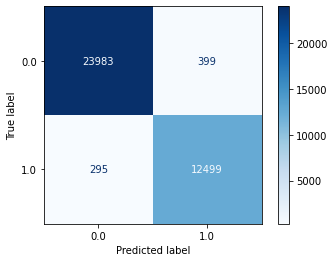

In [70]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

In [71]:
rdf = RandomForestClassifier()
rdf.fit(x_train, y_train)


RandomForestClassifier()

In [72]:
y_pred_rdf = rdf.predict(x_test)

###Random Forest PARÂMETRO 4

In [73]:
avd = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=42)
avd.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       random_state=42)

In [74]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [75]:
accuracy_score(y_test, y_pred_avd)

0.981332042177749

Precisão

In [76]:
precision_score(y_test, y_pred_avd)

0.9690649713133819

Recall

In [77]:
recall_score(y_test, y_pred_avd)

0.9769423167109582

####Matriz de confusão

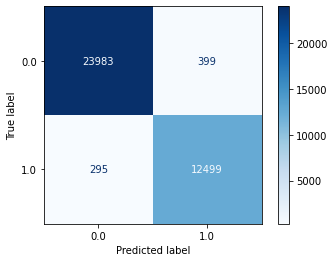

In [78]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

In [79]:
rdf = RandomForestClassifier()
rdf.fit(x_train, y_train)


RandomForestClassifier()

In [80]:
y_pred_rdf = rdf.predict(x_test)

###Random Forest PARÂMETRO 5

In [81]:
avd = RandomForestClassifier(criterion='entropy', max_features='log2', random_state=42)
avd.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       random_state=42)

In [82]:
y_pred_avd = avd.predict(x_test)
y_pred_avd

array([1., 1., 1., ..., 0., 0., 0.])

####Métricas

Acurácia

In [83]:
accuracy_score(y_test, y_pred_avd)

0.981332042177749

Precisão

In [84]:
precision_score(y_test, y_pred_avd)

0.9690649713133819

Recall

In [85]:
recall_score(y_test, y_pred_avd)

0.9769423167109582

####Matriz de confusão

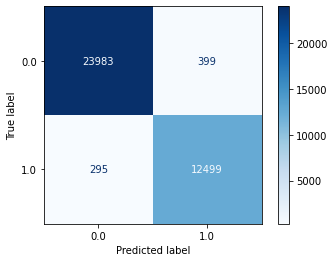

In [86]:
plot_confusion_matrix(avd,x_test,y_test, cmap='Blues')

In [87]:
rdf = RandomForestClassifier()
rdf.fit(x_train, y_train)


RandomForestClassifier()

In [88]:
y_pred_rdf = rdf.predict(x_test)

#Hiperparâmetros: automatizados

##Árvore de decisão

###GridSearch

In [89]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random']}


grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(x_train, y_train.squeeze())

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'splitter': ['best', 'random']})

In [90]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9786354116113001
{'criterion': 'entropy', 'splitter': 'best'}


In [91]:
knn_best = grid_search.best_estimator_
knn_best

DecisionTreeClassifier(criterion='entropy')

In [92]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))
print( 'Precisão: ', precision_score( y_test, y_pred ))

Acc treino:  0.9999193027759845
Acc teste:  0.9790187217559716
Revocação:  0.9700640925433797
Precisão:  0.9690037476577139


###RandomSearch

In [93]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random']}


random_search = RandomizedSearchCV(estimator = DecisionTreeClassifier(), param_distributions=parametros)
random_search.fit(x_train, y_train.squeeze())

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'splitter': ['best', 'random']})

In [94]:
print(random_search.best_score_)
print(random_search.best_params_)

0.9787968022605925
{'splitter': 'random', 'criterion': 'gini'}


In [95]:
knn_best = random_search.best_estimator_
knn_best

DecisionTreeClassifier(splitter='random')

In [96]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))

Acc treino:  0.9999193027759845
Acc teste:  0.9778620615450828
Revocação:  0.9657652024386432


##Random Forest

###GridSearch

In [97]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'n_estimators': [10, 20, 40],
              'criterion': ['gini', 'entropy', 'log_loss'],
               'max_depth': [10,20,30]}



grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid=parametros)
grid_search.fit(x_train, y_train.squeeze())

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [10, 20, 40]})

In [98]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9885947975829978
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 40}


In [99]:
knn_best = grid_search.best_estimator_
knn_best

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=40)

In [100]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))

Acc treino:  0.9886687647944911
Acc teste:  0.9883795997417689
Revocação:  0.9999218383617321


###RandomSearch

In [115]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'n_estimators': [10, 20, 40],
              'criterion': ['gini', 'entropy', 'log_loss'],
               'max_depth': [10,20,30]}



random_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions=parametros)
random_search.fit(x_train, y_train.squeeze())

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30],
                                        'n_estimators': [10, 20, 40]})

In [116]:
print(random_search.best_score_)
print(random_search.best_params_)

0.9884603010790286
{'n_estimators': 20, 'max_depth': 30, 'criterion': 'entropy'}


In [117]:
knn_best = random_search.best_estimator_
knn_best

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=20)

In [118]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))

Acc treino:  0.9885006455777922
Acc teste:  0.9881375080697224
Revocação:  0.9996091918086603


##Naive Bayes

###GridSearch

In [105]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'n_neighbors': [3, 5, 7, 9, 13, 17, 21, 29],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [15, 30, 45, 60]}


grid_search = GridSearchCV(estimator = GaussianNB(), param_grid=parametros)
grid_search.fit(x_train, y_train.squeeze())

ValueError: ignored

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
knn_best = grid_search.best_estimator_
knn_best

In [ ]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))
print( 'Precisão: ', precision_score( y_test, y_pred ))
print( 'F1_score: ', f1_score( y_test, y_pred ))

##Regressão Logística

###GridSearch

In [108]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'penalty': 
              'C': [3, 5, 7, 9, 13, 17, 21, 29],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [15, 30, 45, 60]}


grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid=parametros)
grid_search.fit(x_train, y_train.squeeze())

ValueError: ignored

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
knn_best = grid_search.best_estimator_
knn_best

In [ ]:
y_pred = knn_best.predict(x_test)
print('Acc treino: ', knn_best.score(x_train, y_train ))
print('Acc teste: ', knn_best.score(x_test, y_test.squeeze() ))
print( 'Revocação: ', recall_score( y_test, y_pred ))
print( 'Precisão: ', precision_score( y_test, y_pred ))
print( 'F1_score: ', f1_score( y_test, y_pred ))